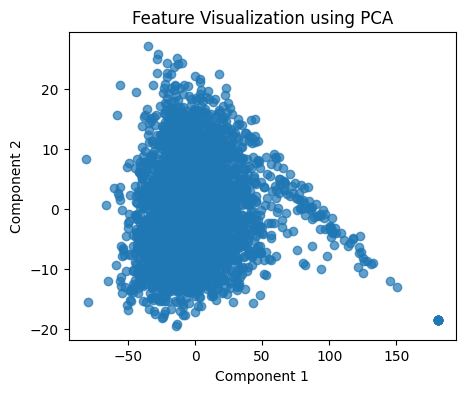

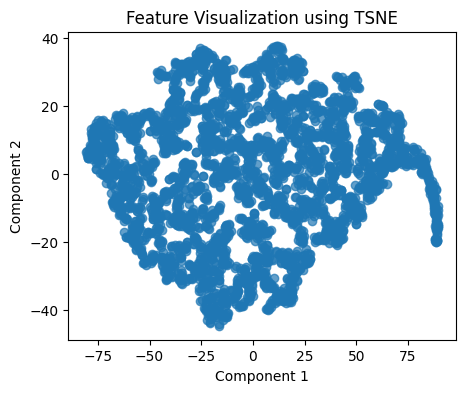

In [2]:
import torch
import torch.nn as nn
import geopandas as gpd
from shapely.geometry import mapping
import rasterio
from rasterio.features import geometry_mask
import numpy as np
import torchvision.transforms as T
from PIL import Image
import h5py
import cv2
from skimage.color import rgb2lab, rgb2gray
from skimage.filters import roberts, sobel
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage.transform import resize
from skimage.util import img_as_ubyte
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Define a transformation to apply to image patches
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
])

def extract_polygon_patch(polygon, image_data, transform):
    """Extract image patch within a polygon"""
    mask = geometry_mask([mapping(polygon)], transform=transform, invert=True, out_shape=(image_data.shape[1], image_data.shape[2]))
    masked_data = np.zeros_like(image_data[:3])
    for i in range(3):
        masked_data[i] = image_data[i] * mask
    bounds = polygon.bounds
    window = rasterio.windows.from_bounds(*bounds, transform=transform)
    row_off = int(window.row_off)
    col_off = int(window.col_off)
    height = int(window.height)
    width = int(window.width)
    patch = masked_data[:, row_off:row_off + height, col_off:col_off + width]
    patch = np.moveaxis(patch, 0, -1)
    patch = Image.fromarray(patch.astype(np.uint8))
    return patch

def process_shapefile(shapefile_path, tif_file_path, transform):
    """Process shapefile to extract patches"""
    polygons = gpd.read_file(shapefile_path)
    patches = []
    with rasterio.open(tif_file_path) as src:
        image_data = src.read()

    for idx, row in polygons.iterrows():
        polygon = row.geometry
        patch = extract_polygon_patch(polygon, image_data, src.transform)

        # Transform the patch and append to the container
        transformed_patch = transform(patch)
        patches.append(transformed_patch)
        
    return patches

def extract_custom_features(img):
    # Color features
    LAB_img = rgb2lab(img)
    A_img = LAB_img[:,:,1]
    A_feat = A_img.mean()
    
    B_img = LAB_img[:,:,2]
    B_feat = B_img.mean()
    
    # Textural features based on the gray image
    gray_img = rgb2gray(img) 
    gray_img = resize(gray_img, (256,256))  # Resize to smaller size
    gray_img = img_as_ubyte(gray_img)
   
    # Entropy
    entropy_img = entropy(gray_img, disk(3))
    entropy_mean = entropy_img.mean()
    entropy_std = entropy_img.std()
    
    roberts_img = roberts(gray_img)
    roberts_mean = roberts_img.mean()

    sobel_img = sobel(gray_img)
    sobel_mean = sobel_img.mean()
    
    # Gabor filters
    kernel1 = cv2.getGaborKernel((9, 9), 3, np.pi/4, np.pi, 0.5, 0, ktype=cv2.CV_32F)    
    gabor1 = (cv2.filter2D(gray_img, cv2.CV_8UC3, kernel1)).mean()
    
    kernel2 = cv2.getGaborKernel((9, 9), 3, np.pi/2, np.pi/4, 0.9, 0, ktype=cv2.CV_32F)    
    gabor2 = (cv2.filter2D(gray_img, cv2.CV_8UC3, kernel2)).mean()

    kernel3 = cv2.getGaborKernel((9, 9), 5, np.pi/2, np.pi/2, 0.1, 0, ktype=cv2.CV_32F)    
    gabor3 = (cv2.filter2D(gray_img, cv2.CV_8UC3, kernel3)).mean()

    custom_features = np.array([A_feat, B_feat, entropy_mean, entropy_std, roberts_mean, 
                                sobel_mean, gabor1, gabor2, gabor3])
    
    return custom_features

def extract_features(patches):
    """Extract custom features"""
    features = []
    for patch in patches:
        patch_np = patch.permute(1, 2, 0).numpy() * 255  # Convert to numpy array and scale back to 0-255
        patch_np = patch_np.astype(np.uint8)
        feature = extract_custom_features(patch_np)
        features.append(feature)
    
    return features

def visualize_features(features, method='pca'):
    """Visualize features using PCA or t-SNE"""
    features = np.array(features)  # Convert features list to numpy array

    if method == 'pca':
        reducer = PCA(n_components=2)
    elif method == 'tsne':
        reducer = TSNE(n_components=2)
    
    reduced_features = reducer.fit_transform(features)
    
    plt.figure(figsize=(5, 4))
    plt.scatter(reduced_features[:, 0], reduced_features[:, 1], alpha=0.7)
    
    plt.title(f'Feature Visualization using {method.upper()}')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

# Example usage
shapefile_path = 'h:\\Yehmh\\DNDF\\202404_DNDF\\seg_merged\\merged_seg_masks.shp'
tif_file_path = 'h:\\Yehmh\\DNDF\\202404_DNDF\\DNDF_merge.tif'

patches = process_shapefile(shapefile_path, tif_file_path, transform)

features = extract_features(patches)

# Save features to HDF5 file
with h5py.File('h:\\Yehmh\\DNDF\\202404_DNDF\\DNDF_202404_CustomFeatures.h5', 'w') as h5f:
    h5f.create_dataset('dataset_1', data=np.array(features))

# Visualize features using PCA
visualize_features(features, method='pca')

# Visualize features using t-SNE
visualize_features(features, method='tsne')
